In [147]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image
%matplotlib inline
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
sns.set_context("notebook")
plt.style.use('dark_background')

In [148]:
df = pd.read_csv('./wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [150]:
X = df.loc[:,2:].values
y= pd.get_dummies(df.iloc[:,1])
y=np.array(y.M)

In [4]:
# from sklearn.preprocessing import LabelEncoder
# X = df.loc[:, 2:].values
# y = df.loc[:,1].values
# le = LabelEncoder()
# y = le.fit_transform(y)
# le.classes_

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [7]:
pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
pipe_lr.score(X_test, y_test)

0.956140350877193

In [8]:
result = y_pred == y_test
np.sum(result == True) / len(result)

0.956140350877193

### 層化k分割交差検証

In [9]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)
trains = []
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(scores)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f'%(k+1, np.bincount(y_train[train]), score))
    trains.append(train)

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956


### sklearnによるcross-validationの評価

In [10]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)

In [11]:
for index, score in enumerate(scores):
    print('%d: %f'%(index, score))

0: 0.934783
1: 0.934783
2: 0.956522
3: 0.956522
4: 0.934783
5: 0.955556
6: 0.977778
7: 0.933333
8: 0.955556
9: 0.955556


In [12]:
print('CV accuracy -> mean: %f, variance: %f'%(np.mean(scores), np.std(scores)))

CV accuracy -> mean: 0.949517, variance: 0.013854


### 学習曲線と検証曲線
学習曲線はループ回数に対する精度の曲線、検証曲線はハイパーパラメータに対する精度の曲線

In [13]:
from sklearn.model_selection import learning_curve

In [14]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                      X=X_train, y=y_train,
                                                      train_sizes=np.linspace(0.1,1.0,10 ),
                                                      cv = 10, n_jobs = 1)

### 学習曲線

(0.8, 1.0)

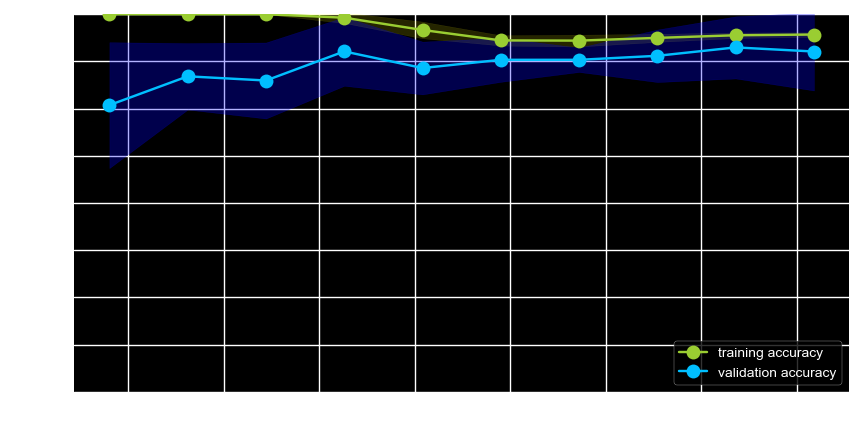

In [15]:
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis=1)
fig = plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_sizes, train_mean, color='yellowgreen', 
         marker='o', markersize=10, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                alpha = 0.15, color='yellow')
plt.plot(train_sizes, test_mean, color='deepskyblue',
        marker='o', markersize=10, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                alpha = 0.3, color='blue')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', frameon=True)
plt.ylim([0.8, 1.0])

### 検証曲線

In [16]:
from sklearn.model_selection import validation_curve

In [17]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1))
params = [10**(-4+i) for i in range(8)]
print(params)
train_scores, test_scores = validation_curve(estimator=pipe_lr,X=X_train, y=y_train,cv = 10,
                                             param_name='logisticregression__C',
                                             param_range=params)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]


(0.8, 1.0)

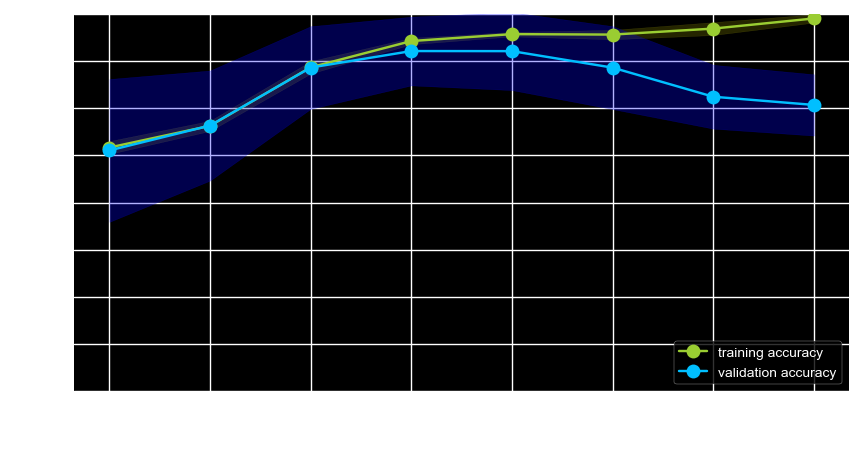

In [18]:
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis=1)
fig = plt.figure(figsize=(10,5), dpi=100)
plt.plot(params, train_mean, color='yellowgreen', 
         marker='o', markersize=10, label='training accuracy')
plt.fill_between(params, train_mean + train_std, train_mean - train_std,
                alpha = 0.15, color='yellow')
plt.plot(params, test_mean, color='deepskyblue',
        marker='o', markersize=10, label='validation accuracy')
plt.fill_between(params, test_mean + test_std, test_mean - test_std,
                alpha = 0.3, color='blue')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', frameon=True)
plt.xscale('log')
plt.ylim([0.8, 1.0])

### 複数のパラメーターを同時にチューニングするグリッドサーチ

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [54]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
params = [10**(-4+i) for i in range(8)]
param_grid = [{'svc__C': params, 'svc__kernel': ['linear']},
             {'svc__C': params, 'svc__gamma': params, 'svc__kernel': ['rbf']}]

In [21]:
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,
                 scoring='accuracy', cv=10, n_jobs=-1)

In [22]:
gs = gs.fit(X_train, y_train)

In [23]:
print(gs.best_params_)

{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [24]:
parameters = [mat[0] for mat in gs.grid_scores_]
score = [mat[1] for mat in gs.grid_scores_]
svc_lin_C = parameters[:len(params)]

/Users/yugi/.pyenv/versions/anaconda-4.0.0/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/yugi/.pyenv/versions/anaconda-4.0.0/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [25]:
svc_lin_C = [c['svc__C'] for c in parameters[:len(params)]]
svc_lin_score = score[:len(params)]
df_lin = pd.DataFrame(np.c_[svc_lin_C, svc_lin_score],columns=['C', 'score'])

In [26]:
svc_kernel_C = [c['svc__C'] for c in parameters[len(params):]]
svc_kernel_gamma = [g['svc__gamma'] for g in parameters[len(params):]]
svc_lin_score = score[len(params):]
df_kernel = pd.DataFrame(np.c_[svc_kernel_C,svc_kernel_gamma, svc_lin_score],columns=['C', 'gamma','score'])

In [27]:
kernel_max = df_kernel.loc[df_kernel['score'].idxmax(),:]
lin_max = df_lin.loc[df_lin['score'].idxmax(),:]

In [28]:
df_kernel.head()

,C,gamma,score
0,0.0001,0.0001,0.626374
1,0.0001,0.0010,0.626374
2,0.0001,0.0100,0.626374
3,0.0001,0.1000,0.626374
4,0.0001,1.0000,0.626374


Text(0.5,1,'SVC kernel parameter validation curve')

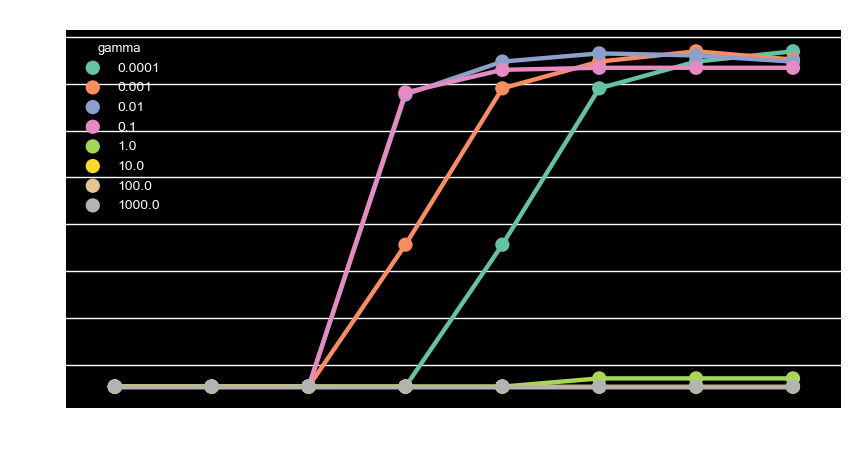

In [29]:
fig = plt.figure(figsize=(10,5), dpi=100)
g = sns.pointplot(x='C', y='score', data=df_kernel, hue='gamma', palette='Set2')
g.set_title('SVC kernel parameter validation curve')

Text(0.5,1,'SVC kernel parameter validation curve')

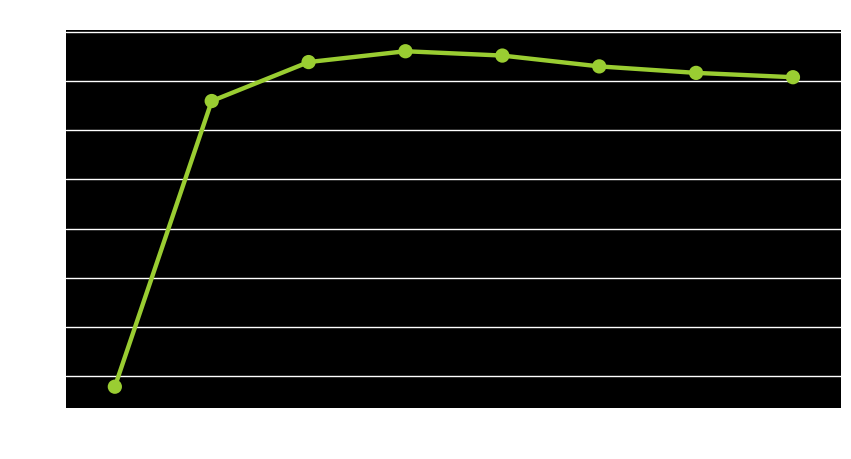

In [30]:
fig = plt.figure(figsize=(10,5), dpi=100)
g = sns.pointplot(x='C', y='score', data=df_lin, color='yellowgreen')
g.set_title('SVC kernel parameter validation curve')

### 入れ子式の交差検証

In [31]:
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,
                 scoring='accuracy', cv=2,n_jobs=-1)

In [32]:
scores = cross_val_score(gs, X_train, y_train,scoring='accuracy', cv=5)
print('average: %f, variation: %f'% (np.mean(scores), np.std(scores)))

average: 0.973626, variation: 0.014906


In [33]:
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,
                 scoring='accuracy', cv=2, n_jobs=-1)
gs = gs.fit(X_train, y_train)
scores = cross_val_score(gs, X_train, y_train,scoring='accuracy', cv=5)
print('average: %f, variation: %f'% (np.mean(scores), np.std(scores)))
print('best is %s'% gs.best_params_)

average: 0.973626, variation: 0.014906
best is {'svc__C': 100, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [34]:
### 決定木で試してみる
from sklearn.tree import DecisionTreeClassifier
params = [{'max_depth': [1,2,3,4,5,6,7,None]}]
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=params,
                 scoring='accuracy', cv=2, n_jobs=-1)
gs.fit(X_train,y_train)
scores = cross_val_score(gs, X_train, y_train,scoring='accuracy', cv=5)
print('average: %f, variation: %f'% (np.mean(scores), np.std(scores)))
print('best is %s'% gs.best_params_)

average: 0.934066, variation: 0.015541
best is {'max_depth': 3}


### Accuracy, Presicion, Recall and F-score

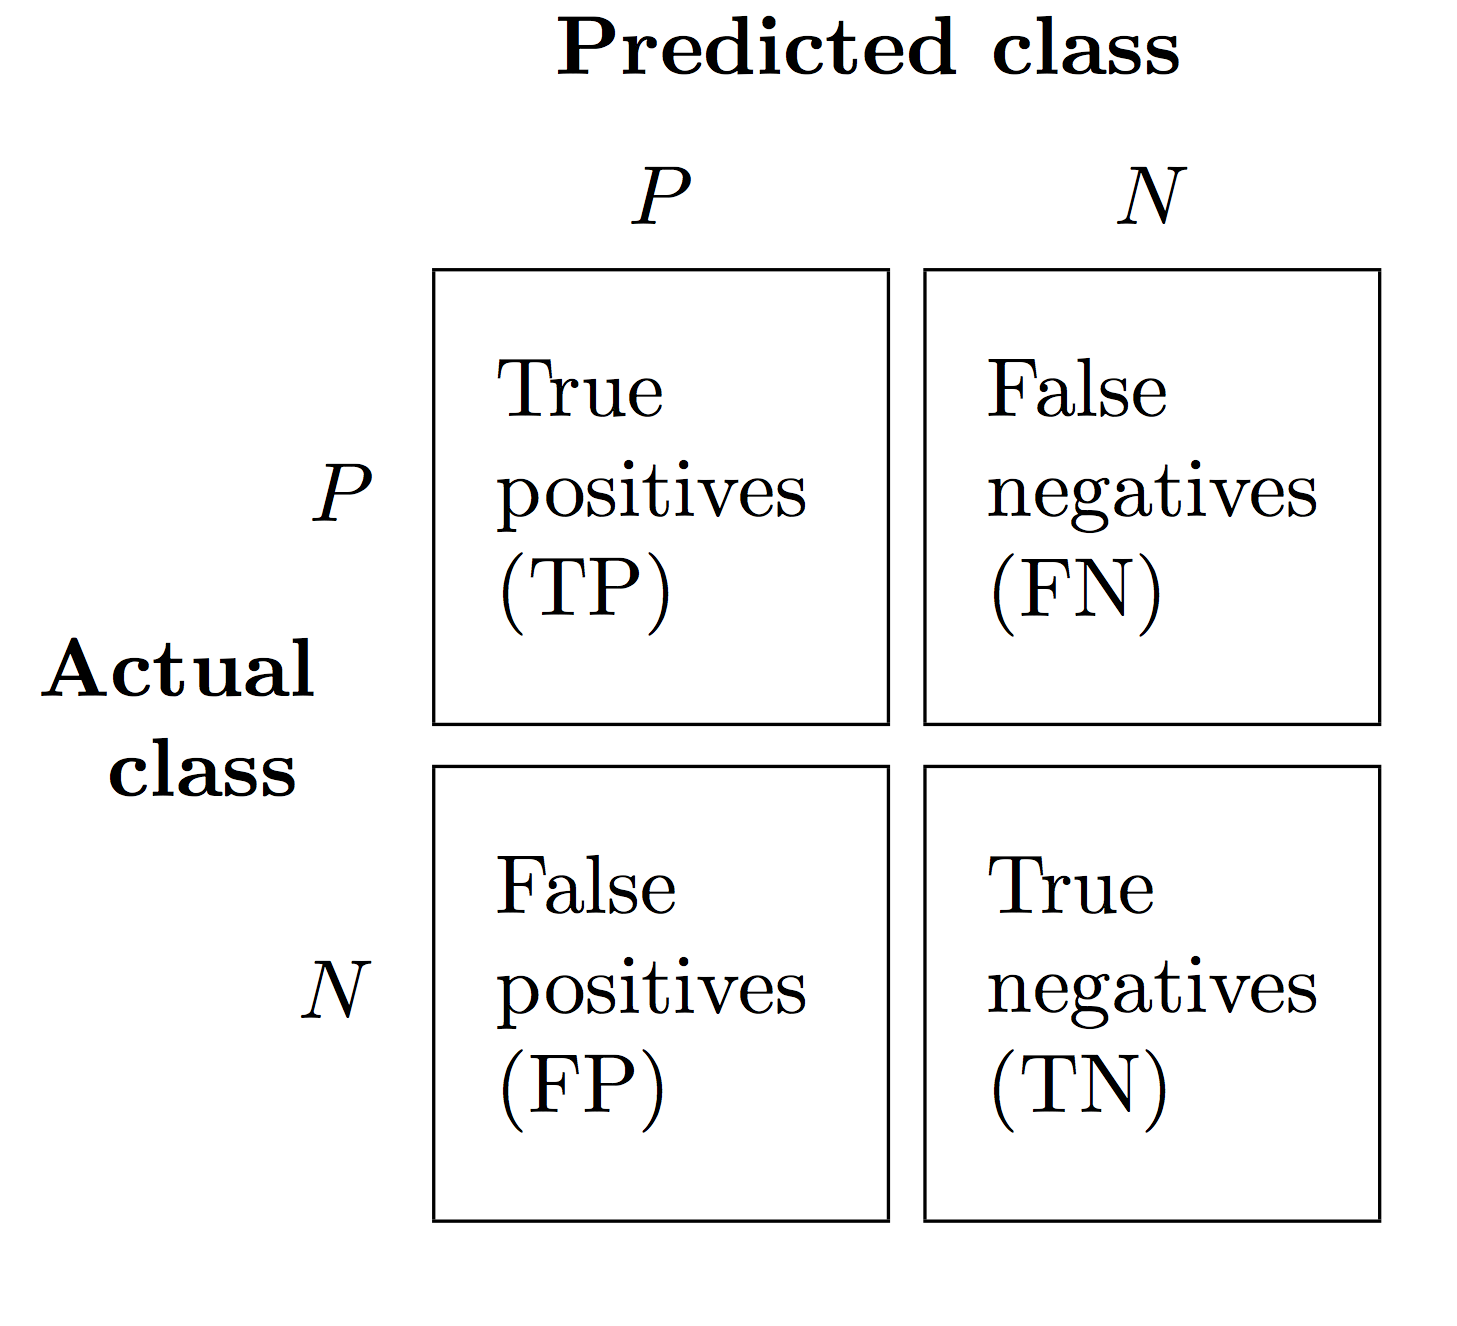

In [43]:
Image('./image1.png', width=300)

In [36]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

In [37]:
## manualでやってみる
match = y_pred == y_test
not_match = y_pred != y_test
tp = y_test[match] == 1
fn = y_test[not_match] == 1
fp = y_test[not_match] == 0
tn = y_test[match] == 0
result = np.array([tn.sum(),fp.sum(),fn.sum(),tp.sum()]).reshape(2,2)

In [44]:
PRE = tp.sum() / (tp.sum()+fp.sum())
REC = tp.sum() / (tp.sum() + fn.sum())
F1 = 2 * (PRE * REC) / (PRE + REC)
print(PRE)
print(REC)
print(F1)

0.975609756097561
0.9523809523809523
0.963855421686747


Text(10.2222,0.5,'true label')

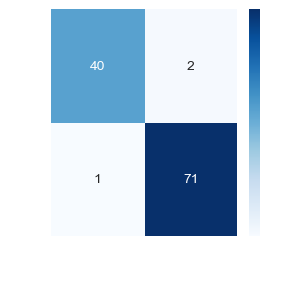

In [39]:
fig = plt.figure(figsize=(3,3), dpi=100)
g = sns.heatmap(result, annot=True, cmap='Blues')
g.invert_xaxis()
g.invert_yaxis()
g.set_xlabel('predicted label')
g.set_ylabel('true label')

In [40]:
### scikit-learnを使ってみる
from sklearn.metrics import confusion_matrix
result2 = confusion_matrix(y_true=y_test, y_pred=y_pred)

In [48]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
PRE = precision_score(y_true=y_test, y_pred=y_pred)
REC = recall_score(y_true=y_test, y_pred=y_pred)
F1 = f1_score(y_true=y_test, y_pred=y_pred)
print(PRE)
print(REC)
print(F1)

0.975609756097561
0.9523809523809523
0.963855421686747


Text(10.2222,0.5,'true label')

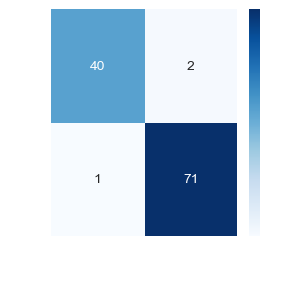

In [41]:
fig = plt.figure(figsize=(3,3), dpi=100)
g = sns.heatmap(result2, annot=True, cmap='Blues')
g.invert_xaxis()
g.invert_yaxis()
g.set_xlabel('predicted label')
g.set_ylabel('true label')

In [57]:
### グリッドサーチの検証にF1値を使用
from sklearn.metrics import make_scorer, f1_score
my_score = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,
                 scoring=my_score, cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print('best score(f1) is %f'%gs.best_score_)
print('best parameter is %s'% gs.best_params_)

best score(f1) is 0.988022
best parameter is {'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


### ROC曲線
ROC曲線のことがよく分かるサイト

<https://qiita.com/kenmatsu4/items/550b38f4fa31e9af6f4f>

<https://qiita.com/kenmatsu4/items/0a862a42ceb178ba7155>

In [59]:
from sklearn.metrics import roc_curve,auc
from scipy import interp

In [61]:
pipe_lr = make_pipeline(StandardScaler(), 
                       PCA(n_components=2),
                       LogisticRegression(penalty='l2', random_state=1, C=100.0))
X_train2 = X_train[:,[4,14]]
cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train, y_train))

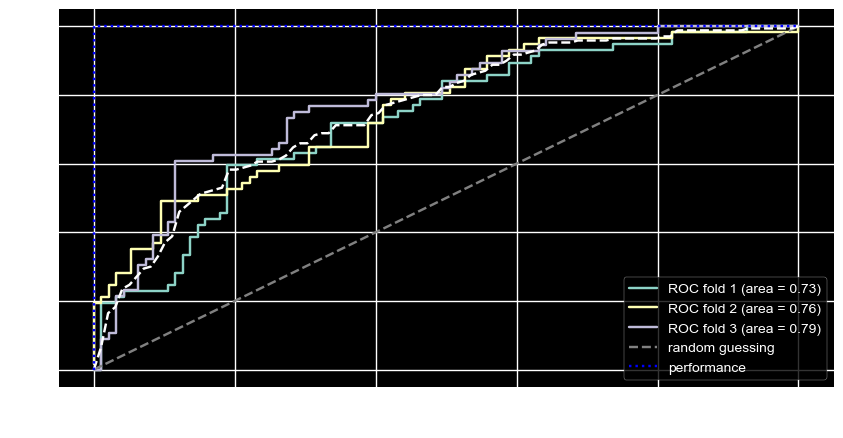

In [98]:
mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)
all_tpr = []
fig = plt.figure(figsize=(10,5), dpi=100)
for i,(train, test) in enumerate(cv):
    fit = pipe_lr.fit(X_train2[train], y_train[train])
    probas = fit.predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:,1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)'%(i+1, roc_auc))

#当て推量
plt.plot([0,1], [0,1], linestyle='--', color='grey', label = 'random guessing')

#FRP, TRP, ROC AUC それぞれの平均を計算してプロット
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', color='white')

#完全に予測が正解したとき
plt.plot([0,0,1],[0,1,1],linestyle=':', color='blue', label = 'performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('ture positive rate')
plt.legend(loc='lower right', frameon=True)

### 不均衡クラスに対する評価

In [123]:
### 意図的に不均衡クラスを作成
X_imb = np.vstack((X[y==0], X[y==1][:40]))
y_imb = np.hstack((y[y==0], y[y==1][:40]))

In [126]:
y_pred = np.zeros(y_imb.shape[0])

In [127]:
np.mean(y_pred==y_imb) * 100

89.92443324937027

In [133]:
### クラス不均衡なモデルの対処法の一つ、アップサンプリングを示す
from sklearn.utils import resample
print('Number of class 1 before: %d'%(X_imb[y_imb==1].shape[0]))
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb==1],
                                   replace = True,
                                   n_samples=X_imb[y_imb == 0].shape[0],
                                   random_state = 123)
print('Number of class 1 after: %d'%(X_upsampled.shape[0]))

Number of class 1 before: 40
Number of class 1 after: 357


In [141]:
X_balanced = np.vstack((X_imb[y_imb==0], X_upsampled))
y_bal = np.hstack((y_imb[y_imb==0], y_upsampled))

In [145]:
print(np.sum(y_bal == 0))
print(np.sum(y_bal == 1))

357
357
